In [1]:
torch.cuda.empty_cache() 

NameError: name 'torch' is not defined

In [92]:
%%bash
git commit -a -m "checkpoint"

[master 37d8e9b] checkpoint
 1 file changed, 4 insertions(+), 4 deletions(-)


https://www.rileynwong.com/blog/2019/2/25/generating-music-with-an-lstm-neural-network

In [ ]:
from IPython.core.debugger import Pdb

# data preparation

In [1]:
max_sequence_length = 100

In [2]:
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for idx in range(0, len(l), n):
        yield l[idx:idx + n]

In [3]:
import glob

import score2df

In [4]:
from score2df import *

In [5]:
from importlib import reload

In [6]:
reload(score2df)

TypeError: reload() argument must be a module

## 差分バージョン

In [13]:
is_difference_based = True

In [11]:
is_discrete = True

In [12]:
from music21 import converter, instrument, note, chord

In [16]:
id = str(is_difference_based) + "_"  + str(is_discrete)

In [19]:
pkl_path = 'saved/df_scores_{}.pkl'.format(id)

In [22]:
is_use_preprocessed_df = False

In [23]:
df_scores = pd.DataFrame()
if is_use_preprocessed_df:
    df_scores = pd.read_pickle(pkl_path)
else:
    for file in glob.glob("chorales/midi/*.mid"):
        df_score = score2df(file)
        df_score = add_lags(df_score)
        df_score = df_score.assign(file = file)
        df_scores = df_scores.append(df_score , ignore_index = True )
        
    df_scores.to_pickle(pkl_path)

In [24]:
df_scores.shape

(239796, 10)

In [25]:
df_scores.describe()

,cent,n,dcent,dcent_lag1,dcent_lag2,dcent_lag3
count,239796.000000,239796.000000,237530.000000,235278.000000,233039.000000,230808.000000
mean,190.483578,1.326382,-2.578622,1.792773,1.397191,1.565370
std,972.031414,1.545788,977.908612,979.009075,981.259277,983.706187
min,-3600.000000,0.000000,-5300.000000,-5300.000000,-5300.000000,-5300.000000
25%,-500.000000,0.000000,-300.000000,-300.000000,-300.000000,-300.000000
50%,200.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,900.000000,2.000000,300.000000,300.000000,300.000000,300.000000
max,3100.000000,14.000000,5500.000000,5500.000000,5500.000000,5500.000000


In [26]:
df_stage = df_scores.query('n == 0')

In [27]:
import numpy as np

In [28]:
if is_discrete:
    dtype = str
else:
    dtype = np.float64

In [29]:
note_set = set(df_stage.dcent.astype(dtype))

In [30]:
len(note_set)

108

In [31]:
type(df_scores.dcent[0])

numpy.float64

In [32]:
notes_list = []
for f in set(df_stage.file):
    df_file = df_stage[df_stage.file == file]
    
    for n in set(df_file.n):
        df_file_n = df_file[df_file.n == n]
        
        run_notes = df_file_n.dcent.astype(dtype)
        for n in split_list(run_notes , max_sequence_length):
            if len(n) > 10:
                notes_list.append(n)
        

In [33]:
len(notes_list)

498

In [34]:
len(notes_list[0])

65

#### linear regresssion


https://www.statsmodels.org/dev/example_formulas.html

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
mod = smf.ols(formula = 'dcent ~ dcent_lag1' , data = df_stage)

In [37]:
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  dcent   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                 8.157e+04
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:12:01   Log-Likelihood:            -7.6526e+05
No. Observations:               92147   AIC:                         1.531e+06
Df Residuals:                   92145   BIC:                         1.531e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8388      3.223     -0.881      0.3

In [38]:
mod = smf.ols(formula = 'dcent ~ dcent_lag1 + dcent_lag2' , data = df_stage)

In [39]:
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  dcent   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                 4.543e+04
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:12:38   Log-Likelihood:            -7.5878e+05
No. Observations:               91649   AIC:                         1.518e+06
Df Residuals:                   91646   BIC:                         1.518e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7590      3.150     -1.193      0.2

## preparation I wrote  (note-basedの場合のhead. ただし、dcent baseのほうが良い可能性大)

In [70]:
from music21 import converter, instrument, note, chord
notes_list = []
note_set = set()
for file in glob.glob("chorales/midi/*.mid"):
    run_notes = []
    print(file)
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        #Pdb().set_trace()
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            run_notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            #Pdb().set_trace()
            run_notes.append('.'.join(str(n) for n in element.normalOrder))
    note_set = note_set | set(run_notes)
    for n in split_list(run_notes , max_sequence_length):
        if len(n) > 10:
            notes_list.append(n)
    #notes_list.append(run_notes)

chorales/midi/028100b_.mid
chorales/midi/026100b_.mid
chorales/midi/028700b_.mid
chorales/midi/032200b_.mid
chorales/midi/065900b_.mid
chorales/midi/061500b_.mid
chorales/midi/006906b_.mid
chorales/midi/012008ba.mid
chorales/midi/001707b_.mid
chorales/midi/016206blpz.mid
chorales/midi/014004b_.mid
chorales/midi/069100b_.mid
chorales/midi/009005b_.mid
chorales/midi/070000b_.mid
chorales/midi/065200b_.mid
chorales/midi/009801b_.mid
chorales/midi/069400b_.mid
chorales/midi/037700b_.mid
chorales/midi/033000b_.mid
chorales/midi/034200b_.mid
chorales/midi/005708b_.mid
chorales/midi/041600b_.mid
chorales/midi/037500b_.mid
chorales/midi/039800b_.mid
chorales/midi/038300b_.mid
chorales/midi/027200b_.mid
chorales/midi/040200b_.mid
chorales/midi/012406b_.mid
chorales/midi/010602b_.mid
chorales/midi/008606b_.mid
chorales/midi/004003b_.mid
chorales/midi/007607b_.mid
chorales/midi/013806b_.mid
chorales/midi/016106b_.mid
chorales/midi/013701b_.mid
chorales/midi/010806b_.mid
chorales/midi/024437b_.mid

https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

## pre-pack procedures

In [35]:
import torch.nn as nn
import torch

### for continuous version

In [52]:

raw_X = [torch.tensor(np.array(notes_list[i])[0:-1]).reshape([-1,1]) for i in range(len(notes_list))]
raw_y = [torch.tensor(np.array(notes_list[i])[1:]) for i in range(len(notes_list))]


### with label encoding (for discrete version)
https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
に概ね準拠仕様と思ったが・・・

- そもそもlabelencoder -> onehot  は今後必要ないよとwarning が出る
- onehot の挙動が読みにくい

のでlabelencodingしたあと直にnp.arrayをmanual onehote化したほうがいいのではないか？？

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
le = LabelEncoder()

In [38]:
le.fit(list(note_set))

LabelEncoder()

In [39]:
import numpy as np

In [40]:
labeled_notes_list = [le.transform(np.array(x)) for x in notes_list]

In [41]:
label_set = set(le.transform(list(note_set)))

In [42]:
raw_X = [torch.zeros(labeled_notes_list[i].shape[0] - 1 , len(label_set)) for i in range(len(notes_list))]

In [43]:
for i in range(len(notes_list)):
    for j in range(labeled_notes_list[i].shape[0]-1):
        raw_X[i][j , labeled_notes_list[i][j]] = 1.

In [44]:
raw_y = [torch.tensor(np.array(x[1:])) for x in labeled_notes_list]

## pad and pack

In [45]:
packed_X = torch.nn.utils.rnn.pack_sequence(raw_X , enforce_sorted=False)

In [46]:
ppd_X = torch.nn.utils.rnn.pad_packed_sequence(packed_X)

In [47]:
packed_y = torch.nn.utils.rnn.pack_sequence(raw_y , enforce_sorted=False)

In [48]:
ppd_y = torch.nn.utils.rnn.pad_packed_sequence(packed_y)

### reference

- [OneHotEncoderだけでいける。LabelEncoderをかます必要なし]と当初思っていたがむしろ逆



https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn

Another possible good reference:
https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn


## mask

In [60]:
mask = torch.Tensor([len(x) - 1 for x in notes_list])

or

In [49]:
mask = ppd_X[1]

# LTSM

参考文献のpreprocessはあまり納得いかないので・・

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

をみつつやってみるか

##  復習

In [ ]:
input_size = 10
hidden_size = 20
num_layers = 1

In [ ]:
rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)

In [ ]:
sequence_length = 5
sequence_num = 3

In [ ]:
input = torch.randn(sequence_length, sequence_num, input_size)

In [ ]:
h0 = torch.randn(num_layers , sequence_num , hidden_size)
c0 = torch.randn(num_layers , sequence_num, hidden_size)
output, (hn, cn) = rnn(input, (h0, c0))

In [ ]:
hn.shape

In [ ]:
output.shape

outputの最後尾（sequence length方向の末尾）とhnは一致する:


In [ ]:
output[4]

In [ ]:
hn

## 復習２

In [ ]:
rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)

In [ ]:
batch_X = ppd_X[0][: , 0:10 ]
batch_y = ppd_y[0][:,  0:10]

In [ ]:
sequence_num = batch_X.shape[1]

In [ ]:
h0 = torch.randn(num_layers , sequence_num , hidden_size)
c0 = torch.randn(num_layers , sequence_num, hidden_size)
output, (hn, cn) = rnn(batch_X, (h0, c0))

In [ ]:
output.shape

## main

### simple model

input_size = len(ohe.get_feature_names())
hidden_size = 50
num_layers = 1

In [ ]:
input_size = ppd_X[0].shape[2]
hidden_size = ppd_X[0].shape[2]
num_layers = 1

In [ ]:
class my_model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(my_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)

        #self.linear = nn.Linear(hidden_size, input_size) #output dimension has to be identical with the input dimension
        #self.softmax = nn.functional.softmax()


    def forward(self, input):
        sequence_num = input.shape[1]
        self.h0 = torch.randn(self.num_layers , sequence_num , self.hidden_size)
        self.c0 = torch.randn(self.num_layers , sequence_num, self.hidden_size)
        y, (hn, cn) = self.rnn(input, (self.h0, self.c0))
        #y = self.linear(y)
        y = nn.functional.softmax(y , dim = 2)
        return y
    

In [ ]:
model = my_model(input_size , hidden_size , num_layers)

### 参考文献に似せたモデル
https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
に似せたモデル
現状ランダムの1.8倍程度の正答率にしかならないと思っていたがsoftmaxを二重にかけていた問題を解決したら劇的にパフォーマンスが向上した

In [50]:
input_size = ppd_X[0].shape[2]
hidden_size = 256 
num_layers = 2
dropout = 0.1

In [51]:
class my_model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers , dropout):
        #super(my_model, self).__init__()
        
        super().__init__()
        #self.input_size = input_size
        #self.hidden_size = hidden_size
        #self.num_layers = num_layers
        self.relu1 = nn.ReLU()


        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers , dropout=dropout)

        self.linear = nn.Linear(hidden_size, input_size) #output dimension has to be identical with the input dimension
        
        
        #self.sm = nn.Softmax(dim = 2)
      


    def forward(self, input):
        #self.h0 = torch.randn(self.num_layers , sequence_num , self.hidden_size)
        #self.c0 = torch.randn(self.num_layers , sequence_num, self.hidden_size)
        y, (hn, cn) = self.rnn(input)#, (self.h0, self.c0))
        y = self.linear(y)
        y = self.relu1(y)
        #y = nn.functional.softmax(y , dim = 2)
        #y = self.sm(y)
        return y
    

In [52]:
model = my_model(input_size , hidden_size , num_layers , dropout)

## dimensionality check

In [53]:
y_tmp = model.forward(ppd_X[0][:, 0:10])

In [54]:
y_tmp.shape

torch.Size([64, 10, 108])

##    連続バージョン

https://stackoverflow.com/questions/49040180/change-tanh-activation-in-lstm-to-relu

In [121]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout):
        """"Constructor of the class"""
        super(LSTMCell, self).__init__()

        self.nlayers = nlayers
        self.dropout = nn.Dropout(p=dropout)

        ih, hh = [], []
        for i in range(nlayers):
            ih.append(nn.Linear(input_size, 4 * hidden_size))
            hh.append(nn.Linear(hidden_size, 4 * hidden_size))
        self.w_ih = nn.ModuleList(ih)
        self.w_hh = nn.ModuleList(hh)

    def forward(self, input, hidden):
        """"Defines the forward computation of the LSTMCell"""
        hy, cy = [], []
        for i in range(self.nlayers):
            hx, cx = hidden[0][i], hidden[1][i]
            gates = self.w_ih[i](input) + self.w_hh[i](hx)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)

            i_gate = F.sigmoid(i_gate)
            f_gate = F.sigmoid(f_gate)
            c_gate = F.tanh(c_gate)
            o_gate = F.sigmoid(o_gate)

            ncx = (f_gate * cx) + (i_gate * c_gate)
            nhx = o_gate * F.tanh(ncx)
            cy.append(ncx)
            hy.append(nhx)
            input = self.dropout(nhx)

        hy, cy = torch.stack(hy, 0), torch.stack(cy, 0)
        return hy, cy

# criterion (cross entropy lossはlog softmaxを含んでいるので二重に作用させないよう注意が必要？）

cross entropy for one-hot representation
https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/4

one-hotのままでなくて、Rでいうところのfactorに戻したほうがよさそう（？）


In [55]:
criterion = nn.CrossEntropyLoss(reduction='sum')


input has to be a Tensor of size either (minibatch, C)(minibatch,C) or (minibatch, C, d_1, d_2, ..., d_K)

## crossentropyの使い方

### simplest example

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [ ]:
target

In [ ]:
output = criterion(input, target)

### まとめて評価する場合（ただし、maskの適用方法がopen problem)

In [ ]:
criterion(y_tmp.permute(1 , 2,0 ) , batch_y.transpose(0,1))

In [ ]:
criterion(y_tmp.transpose(0 , 1).transpose(1,2) , batch_y.transpose(0,1))

# GPU tool

In [56]:
#https://qiita.com/elm200/items/46633430c456dd90f1e3
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

In [57]:
is_use_gpu = True


In [58]:
if is_use_gpu:
    model = try_gpu(model)

# optimizer

In [59]:
import torch.optim as optim# optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [69]:
optimizer = optim.Adam(model.parameters())

# optimization

In [61]:
from IPython.display import display

In [62]:
sample_size = ppd_X[0].shape[1]

In [63]:
batch_size = 20

In [64]:
batch_indices = range( 0 ,sample_size ,  batch_size)

## n epochs

In [65]:
n_epochs = 200

In [66]:
losses = []

In [67]:
prob_when_random = 1 / len(note_set)

In [70]:
for k in range(n_epochs):
    batch_loss = 0
    shuffled_idx = torch.randperm(sample_size)
    for i in batch_indices:
        #display(".")
        batch_samples = shuffled_idx[i:min(i + batch_size , sample_size) ]

        batch_X = ppd_X[0][: , batch_samples]
        batch_y = ppd_y[0][:,  batch_samples]        
        batch_mask = mask[batch_samples]
        
        if is_use_gpu:
            batch_X = try_gpu(batch_X)
            batch_y = try_gpu(batch_y)

            batch_mask = try_gpu(batch_mask)

        model.zero_grad()

        batch_y_model = model(batch_X)

        loss = 0

        for j in range(batch_y.shape[1]):
            loss += criterion( batch_y_model[0:batch_mask[j] , j ] , batch_y[0:batch_mask[j] , j])
        batch_loss += loss.item()
        loss.backward()

        optimizer.step()
    batch_loss /= torch.sum(mask).item()
    losses.append(batch_loss)
    mean_correct_prob = np.exp(-batch_loss)
    
    if k % 10 == 0:
        display("epoch : {}   loss : {}   correct prob : {} correct / random : {}".format(k , batch_loss ,
                                                                        mean_correct_prob ,
                                                                        mean_correct_prob / prob_when_random))


'epoch : 0   loss : 0.8344782289252224   correct prob : 0.43410092365785097 correct / random : 46.88289975504791'

'epoch : 10   loss : 0.7317568499400434   correct prob : 0.48106309158579813 correct / random : 51.9548138912662'

'epoch : 20   loss : 0.731689389929714   correct prob : 0.4810955452015739 correct / random : 51.95831888176998'

'epoch : 30   loss : 0.7316593530187645   correct prob : 0.48110999604265153 correct / random : 51.95987957260637'

'epoch : 40   loss : 0.7316430065047789   correct prob : 0.4811178605782092 correct / random : 51.9607289424466'

'epoch : 50   loss : 0.731631706038632   correct prob : 0.4811232974650249 correct / random : 51.96131612622269'

'epoch : 60   loss : 0.7316234523512752   correct prob : 0.48112726852269017 correct / random : 51.96174500045054'

'epoch : 70   loss : 0.7316174009238859   correct prob : 0.48113018003823005 correct / random : 51.96205944412885'

'epoch : 80   loss : 0.731612603827174   correct prob : 0.48113248807177067 correct / random : 51.962308711751234'

'epoch : 90   loss : 0.731608900200411   correct prob : 0.48113427001022985 correct / random : 51.962501161104825'

'epoch : 100   loss : 0.7316054014795755   correct prob : 0.4811359533676698 correct / random : 51.96268296370834'

'epoch : 110   loss : 0.7316025232215483   correct prob : 0.4811373382030827 correct / random : 51.96283252593293'

'epoch : 120   loss : 0.7316004377771094   correct prob : 0.4811383415893153 correct / random : 51.962940891646056'

'epoch : 130   loss : 0.7315980555063271   correct prob : 0.481139487792494 correct / random : 51.96306468158935'

'epoch : 140   loss : 0.7315955717400854   correct prob : 0.4811406828319954 correct / random : 51.963193745855506'

'epoch : 150   loss : 0.7315938750424059   correct prob : 0.481141499182968 correct / random : 51.96328191176055'

'epoch : 160   loss : 0.7315929232830982   correct prob : 0.4811419571140861 correct / random : 51.9633313683213'

'epoch : 170   loss : 0.7315915061766842   correct prob : 0.4811426389439227 correct / random : 51.96340500594365'

'epoch : 180   loss : 0.7315904414318651   correct prob : 0.48114315123832746 correct / random : 51.96346033373937'

'epoch : 190   loss : 0.7315896543633028   correct prob : 0.4811435299311248 correct / random : 51.963501232561484'

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

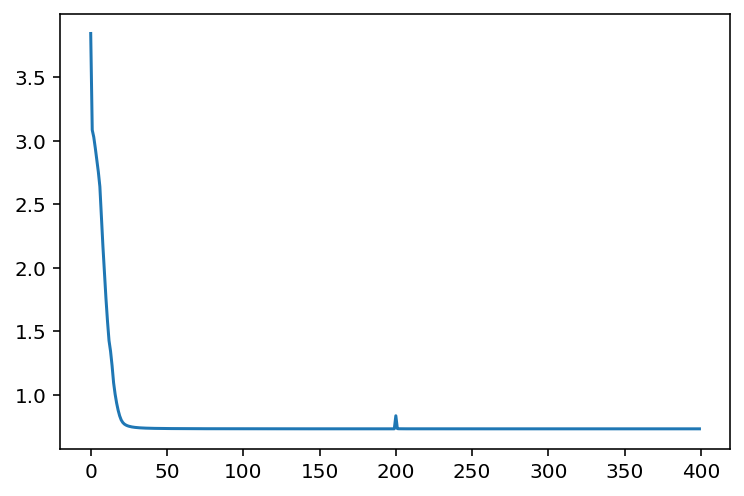

In [72]:
plt.plot(losses)

### save model

https://qiita.com/jyori112/items/aad5703c1537c0139edb

In [73]:
torch.save(model.state_dict() , 'saved/model20191027_{}'.format(id))

### check errors

In [111]:
from plotnine import *

/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


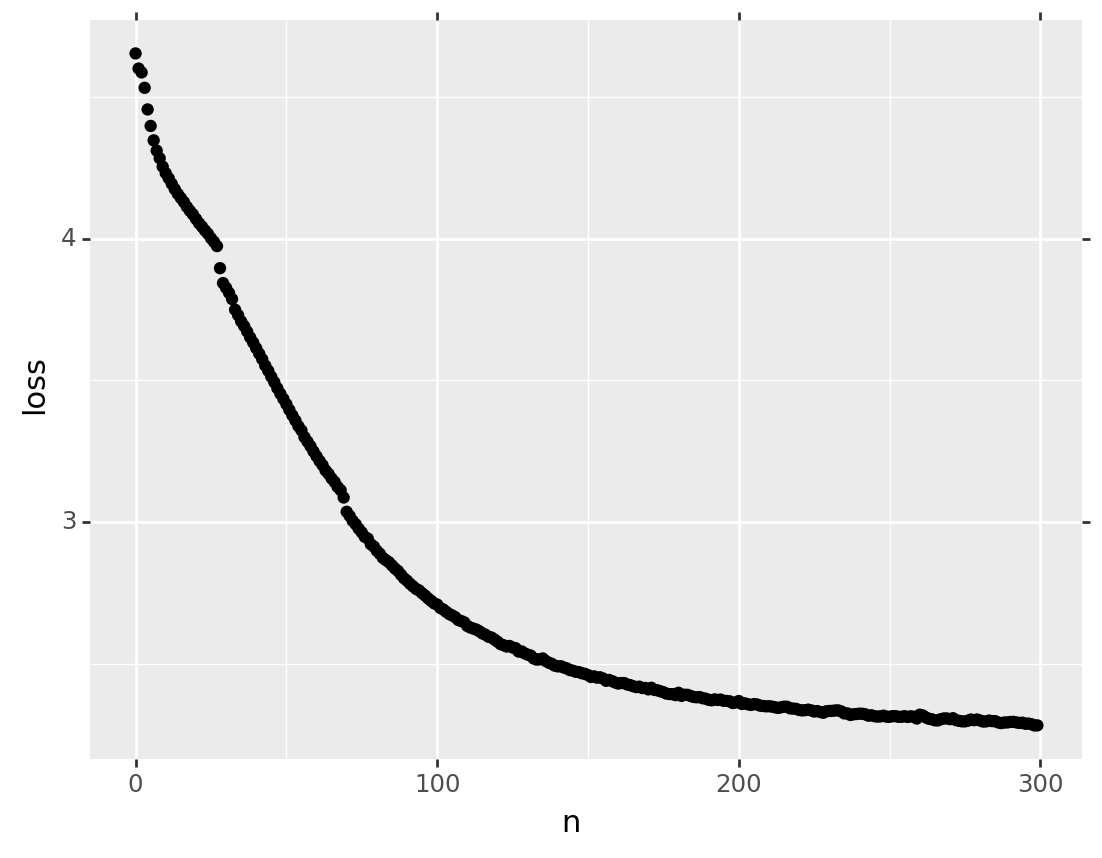

<ggplot: (8766901800687)>

In [112]:
ggplot(pd.DataFrame({'n':range(len(losses)) , 'loss':losses}) , aes(x = 'n' , y ='loss')) + geom_point()

# my own try and error　（この節のプロセスは必要ない）

In [ ]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *

In [ ]:
environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

In [ ]:
s = corpus.parse('bach/bwv65.2.xml')

In [ ]:
s.analyze('key')

In [ ]:
s.show('midi')

In [ ]:
[type(x) for x in s.getElementsByClass(stream.Stream)] #a lot of "Part"s
[[print(type(y)) for y in x.getElementsByClass(stream.Stream)] for x in s.getElementsByClass(stream.Stream)]
[print(x) for x  in s.flat.getElementsByClass(note.Note)]#example of how to flatten the score
#unlike the deepjazz example, each Parts consists of "Measure"s
type(s)#score

#scoreとPartとMeasureがstreamの基本的なsubclass
#scoreがpartを複数含み、partはmeasureを複数持つ

# Before starting the note...
Useful tips for jupyter notebook:

https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [ ]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない

参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM


In [ ]:
us = environment.UserSettings() #不必要

#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'

# install musescore in linux (apt-getでインストールするのがポイント）

For all those who will struggle with displaying scores from music21 within Jupyter Notebook on Linux (e.g. Ubuntu), follow these steps:
https://stackoverflow.com/questions/49939275/python-music21-library-create-png-from-stream/49945456#49945456

MuseScoreのバージョンが2から3にあがっていたので、初期設定のままではうごきませんでした。
https://qiita.com/nofrmm/items/c3662555b145f6b42d92

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore'

In [ ]:
environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")
#environment.set("musicxmlPath", "/snap/bin/musescore")

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore.mscore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore.mscore'

In [ ]:
%load_ext music21.ipython21　#不必要

# sandbox

# シンプルな例からスタート

## note
### noteの追加

insert works as expected if it is "Note to Stream"

In [ ]:
st1=stream.Stream()
st1.insert(0,note.Note("B-5"))

In [ ]:
st1.show()

位置を指定して挿入する場合はinsertを使う

In [ ]:
st1=stream.Stream()
st1.insert(0,note.Note("B-4"))
st1.insert(1,note.Note("B-4"))
st1.insert(2,note.Note("B#3"))
st1.insert(3,note.Note("B#3"))
st1.insert(4 , note.Note("B3"))
st1.insert(4 , note.Note("B2"))
st1.insert(5 , note.Note("C4"))
st1.insert(9 , note.Note("C4"))
st1.show()

appendは最後に追加してくれるので位置の指定をしなくてよくて便利

In [ ]:
st1.append(note.Note("C4"))
st1.show()

### 音のシフト
C4をMajor 3rd(長三度)だけシフトした音すなわちE4を追加

In [ ]:
st1=stream.Stream()
st1.insert(0 , note.Note("C4"))
st1.insert(6 , note.Note("C4").transpose("M3"))
st1.show()

E4をdouble diminished 6th（重減６度？）だけシフトした音を追加。
ただし、double diminishedやdouble augumentedが実際に使われることはまれとのこと。
（https://en.wikipedia.org/wiki/Interval_(music)#Main_intervals
を参照。日本語版wikipediaはいまいちなので英語版を見ること）



その他の参考URL：

http://guitarchord-lab.com/theory/interval.html



In [ ]:
st1 = stream.Stream()
st1.append(note.Note("E4"))
st1.append(note.Note("E4").transpose("M6"))
st1.append(note.Note("E4").transpose("m6"))
st1.append(note.Note("E4").transpose("d6"))
st1.append(note.Note("E4").transpose("dd6"))
st1.show()

なお、例えばC4の重減六度なるものは存在しないっぽい。したがって普通にラ（長６度・Major 6th）がappendされてしまう。

In [ ]:
st1=stream.Stream()
st1.append(note.Note("C4"))
st1.append(note.Note("C4").transpose("M6"))
st1.append(note.Note("C4").transpose("m6"))
st1.append(note.Note("C4").transpose("d6"))
st1.append(note.Note("C4").transpose("dd6"))
st1.show()

そして６度には完全６度というものは存在しない

In [ ]:
st1=stream.Stream()
st1.append(note.Note("C4").transpose("P6")) #returns error

完全５度がなぜ完全ともみなされてきたか？それはドとソの周波数比がほぼほぼ2:3になっているから。
すなわち、$2^{7/12}\approx 1.5$であるから：

In [ ]:
print(2**(7/12))

同様に完全４度はほぼほぼ３：４になっている。すなわち、
$2^{5/12}\approx\frac{4}{3}$：

In [ ]:
print(2**(5/12))

（時間的な）offsetの範囲を調べるには以下のようにすればいいだろう（？）

In [ ]:
st1 = stream.Stream()
st1.append(note.Note("E4"))
st1.append(note.Note("E4").transpose("M6"))
st1.append(note.Note("E4").transpose("m6"))
st1.append(note.Note("E4").transpose("d6"))
st1.append(note.Note("E4").transpose("dd6"))
max_offset = max([x.offset for x in st1])
print(max_offset)

最後に付け加えるのをinsertでやるのであれば、以下のようにすればよいだろう

In [ ]:
st1.insert(max_offset + 1 , note.Note("C3"))
st1.show()

appendは以下のようにまとめて行うことができる（ただし、和音を付け加えるような動作ではない）

In [ ]:
st1.append([note.Note("D4") , note.Note("E4")])
st1.show()

以下のように和音を追加することはできない・・

In [ ]:
st1.insert(max_offset + 1 , [note.Note("D4") , note.Note("E4")]) #returns error

あるoffsetの範囲を切り取るには・・・

In [ ]:
st1.getElementsByOffset(0,4).show()

ただし、ヒエラルヒーがある場合の切り取り方はまだ試行削除中・・

### 音の高さの差

#### 半音を100とするfloatで取出

In [ ]:
interval.notesToChromatic(note.Note("D5") , note.Note("D#4")).cents

In [ ]:
run_diff = interval.notesToChromatic(note.Note("D4") , note.Note("D4#"))

In [ ]:
run_diff.cents

#### 逆

In [ ]:
note.Note("C0").transpose(1).nameWithOctave

### 音の大きさ（velocity)

In [ ]:
n= note.Note("B-4")
n.volume.velocity = 200

### テンポ

In [ ]:
run_score = stream.Score()
bpm = 180
run_score.insert(0.0, tempo.MetronomeMark(number=bpm)) 

### 音のoffset

floatで指定されている場合とfraction.fractionで指定されている場合があるので統計処理する場合はfloat()でcastしてやる必要がある

## 楽器の指定、key signature（調記号・調号）の追加など

In [ ]:
st3=stream.Stream()
st3.append(note.Note("C4"))
st3.append(instrument.ElectricGuitar())
st3.append(note.Note("C4"))
st3.append(instrument.Piano())
st3.append(note.Note("C4"))
st3.append(key.KeySignature(1))
st3.append(note.Note("C4"))
st3.append(key.KeySignature(2))

上記でいいのか？
(慣習的にどうかはともかく入力として許容されるのか？)

↑たぶんダメ。楽器はinsertで指定すべき！

In [ ]:
st3.getInstrument()

In [ ]:
[x for x in st3.getInstruments()]

### 楽器名の文字列での取り出し方

In [ ]:
st3.getInstrument().instrumentName

## score, part, measureについて

scoreとPartとMeasureがstreamの基本的なsubclass

scoreがpartを複数含み、partはmeasureを複数持つ、というのが基本的なScoreの構成（deep jazzの例のようにそうでないヒエラルヒーを持つ場合もある）。
この「基本的な構成」を持つ例としてバッハの楽譜xmlファイルを読み込む

In [ ]:
s_bach = corpus.parse('bach/bwv65.2.xml')

このscoreは４つのPartから構成される。

各Partは各楽器に対応していて、それぞれひとつずつPartがある。

In [ ]:
[type(x) for x in s_bach.getElementsByClass(stream.Stream)] #a lot of "Part"s

このBachの例ではPartはmeasure(小節)から成る。

In [ ]:
[" ".join([str(type(y)) for y in x.getElementsByClass(stream.Stream)]) for x in s_bach.getElementsByClass(stream.Stream)]

ただし、

http://web.mit.edu/music21/doc/usersGuide/usersGuide_06_stream2.html

に注意があるように、PartはtimeSignatureやkeySignatureなども格納できるので、getElementByClassでアクセスするほうが安全:

In [ ]:
print(len([x for x in s_bach]))
print(len([type(x) for x in s_bach.getElementsByClass(stream.Stream)] ))

### appendの動作
noteを追加すると後ろに音を追加
streamのsubclassを追加した場合はヒエラルヒーを構成する、けれど時間的順序はnoteを追加した場合と同じ？？？

In [ ]:
st0 = stream.Stream()
st0.append(note.Note("D4"))
st1 = stream.Stream()
st1.append(note.Note("C4"))
st0.append(st1)
st0.show()

In [ ]:
st0 = stream.Stream()
st0.append(note.Note("D4"))
st1 = stream.Stream()
st1.append(note.Note("C4"))
st2 = stream.Stream()
st2.append(st0)
st2.append(st1)
st2.show()

In [ ]:
[type(i) for i in st2]

In [ ]:
st0 = stream.Stream()
st0.insert(0, note.Note("D4"))
st1 = stream.Stream()
st1.insert(0,note.Note("C4"))
st2 = stream.Stream()
st2.append(st0)
st2.append(st1)
st2.show()

In [ ]:
[type(i) for i in st2]

In [ ]:
st0 = stream.Stream()
st0.insert(0, note.Note("D4"))
st1 = stream.Stream()
st1.insert(0,note.Note("C4"))
st2 = stream.Stream()
st2.insert(0 , st0)
st2.insert(0, st1)
st2.show()

In [ ]:
[type(i) for i in st2]

### 上記のヒエラルヒーと異なる構造を持つ例

deepjazzの例では

Score (midi_data) > Part (melody_stream) > Voice (melody1,2 , melody_voice) ＞ Note

という階層に従ってデータを切り出しているように見える。
すなわちPartはMeasureを持たず、その代わり（？）にVoice(声)を持っている：

In [ ]:
s_jazz = converter.parse('C:/Users/t/PycharmProjects/deepjazz_in_a_file/midi/original_metheny.mid')

In [ ]:
s_jazz_parts = [x for x in s_jazz.getElementsByClass(stream.Part)]
len(s_jazz_parts)

partは楽器が指定してあったりなかったり。

In [ ]:
[x.getInstrument() for x in s_jazz.getElementsByClass(stream.Part)]

In [ ]:
s_jazz_part0_voices = [x for x in s_jazz_parts[0].getElementsByClass(stream.Voice)]
len(s_jazz_part0_voices)

partの構成要素であるvoiceにも同様にinstrumentが指定してあったりしなかったり。おそらく、partレベルで指定しておき、それが構成要素であるvoiceに遺伝している形か

In [ ]:
[x.getInstrument() for x in s_jazz_parts[a].getElementsByClass(stream.Voice)]

In [ ]:
s_jazz_part0_voices.show()

In [ ]:
s_jazz_part0_voices[0].show()

VoiceのなかにMeasureがあるかと思いきやそんなものはない：

In [ ]:
len(s_jazz_part0_voices[0].getElementsByClass(stream.Measure))

ではなにが入っているかといえば、（ScoreのなかのPartのなかの）各PartのVoice[0]はおおむねChordから構成されている（他はnote.Rest, note.Noteが少々）：

In [ ]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[0]])

おそらく各パートのvoice[1]以降はおおむねnoteから構成されている（？）

であるが、deepjazzでchordパートを切り出す際にはそのように決め打つことなく、solo_stream[0]からremoveByClassでnoteを除外しつつすべてのchordを抽出している。
また、melodyパートはsolo_stream[-1]から特に除外操作をすることなくすべてのnoteを抽出できている（？）

In [ ]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[1]])

http://www.mathgram.xyz/entry/plotly の下のほうを参考に（上の方は冗長）

In [ ]:

# Get melody part, compress into single voice.
melody_stream = s_jazz[5]     # For Metheny piece, Melody is Part #5.
melody1, melody2 = melody_stream.getElementsByClass(stream.Voice)

In [ ]:
# import plotly as offline mode
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=False)

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()
columns = iris.feature_names

# make dataframe
df = pd.DataFrame(iris.data, columns=columns)

# make trace
trace = go.Scatter(
    x = np.array([float(j.offset) for j in melody1][0:1000]),
    y = np.array([float(j.offset) for j in melody2][0:1000]),
    mode = "markers")

# define layout
layout = go.Layout(
    showlegend=False)

data = [trace]
fig = dict(data=data, layout=layout)
offline.iplot(fig)

### voice（声）とは？

https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q125207687
参照。
- 例えば合唱であれば、３声というのは三人で歌っているイメージ。
- ピアノの場合、おなじことをひとりでできてしまうので単一のピアノパートのなかに複数のvoiceがありえる（ということか？）

さらに推理すれば、

- midiのなかのpartの分け方に恣意性はないが、そのなかのvoiceへの切り方には恣意性がある（切り分け方を変えても出てくる音は変わらない）ために、partのなかのvoiceはそもそもmergeすべき存在であると言えるか
- メセニーの例でもパート５に存在するふたつのvoiceを「すべて」マージしてしまっている





### accompaniment  (伴奏) part

メセニーの例ではパート0,1,6,7が伴奏パートとのこと。
- ではそれ以外は？？？
- その他の多くのパートには楽器が登録されていない。
- ただし、パート１１はパートゼロと同じくピアノがアサインされている。

パート２はなにか意味があるような内容に見えるが・・・

In [ ]:
s_jazz[2].show()

他方、パート１１はずっとソ＃をたたいているだけ

In [ ]:
s_jazz[11].show()

### フラット化

フラット化してもクラスは変わらない。すなわち、
+ stream.Streamをフラットにするとフラットなstream.Streamが
+ stream.Scoreをフラットにするとフラットなstream.Scoreが

できることになる。

そして、それぞれダイレクトにnoteが収納されている。

In [ ]:
st1.flat

In [ ]:
" ".join([str(type(x)) for x  in s_bach.flat.getElementsByClass(note.Note)])#example of how to flatten the score

In [ ]:
" ".join([str(type(x)) for x  in s_jazz.flat.getElementsByClass(note.Note)])#example of how to flatten the score

In [ ]:
print(type(s_bach.flat))#score
print(type(s_jazz.flat))#score

### flat化およびvoice, partの使い分けについて

- flat化してひとつのvoiceに収納することが例えばdeep learningに突っ込むための合理的な前処理 
- ただし、複数の楽器をまとめたオブジェクトの構成部品はpartでなくてはならない

## chord（和音）について

ChordもNoteもGeneralNoteの派生クラス

参考URL：
http://web.mit.edu/music21/doc/moduleReference/moduleNote.html#music21.note.GeneralNote

deep jazzの解明のためにはChord、すなわち「和音」の理解が重要そうなので少し深堀してみる

参考URL:
http://web.mit.edu/music21/doc/usersGuide/usersGuide_07_chords.html

chord（和音）の作り方：

In [ ]:
cMinor = chord.Chord(["C4", "G4","E-5"])

In [ ]:
cMinor.show()

In [ ]:
len(cMinor)

### pitch(音高)
noteにはpitch（音高）があるが、

In [ ]:
note.Note("C4").pitch

Chord（和音）にはpitchはない：

In [ ]:
cMinor.pitch # returns errof

そのかわりpitchesがある：

In [ ]:
cMinor.pitches

### MajorかMinorか
MajorかMinorかを判別してくれるメソッドはこれ：

In [ ]:
cMinor.isMajorTriad()

英和対応：
+ triad : 三和音
+ major triad : 長三和音
+ minor triad : 短三和音

日本語wikipedia
https://ja.wikipedia.org/wiki/%E7%9F%AD%E4%B8%89%E5%92%8C%E9%9F%B3
によれば、短三和音は
+ base
+ base + m3
+ base + P5
によって構成される三和音とのことだが・・・

In [ ]:
cMinor.isMinorTriad()

はTrueになるのでisMinorTriadの判定基準は日本語wikipediaの定義と異なる？

というより、オクターブの違いは無視している(すわわちmod 12)ということか?

より近接した音で構成される和音に変えるには以下のようにする：

In [ ]:
cMinor.closedPosition().show()

コードの「名前」を知りたければ以下のようにする：

In [ ]:
print(cMinor.commonName)

メソッドisMajorTriadが何をやっているかは以下で解明できるはず：（だがスキップして先に進もう）

In [ ]:
cMinor.isMajorTriad??

ドミソをミソドにしたようなのを展開形という。展開形かどうかのチェックは以下のようにする：

In [ ]:
cMinor.inversion()

## scale(音階)について

In [ ]:
scaleType = scale.MajorScale()

http://web.mit.edu/music21/doc/moduleReference/moduleScale.html

によれば

ConcreteScale.derive(other, comparisonAttribute='pitchClass')

Return the closest-matching ConcreteScale based on the pitch collection provided as a Stream, a ConcreteScale, or a list of Pitch objects.

要は音階がドミソ（すべて白鍵）ならドレミファソラシド（すべて白鍵）が含まれているC Major音階と推定するような感じか。
推定アルゴリズムは変化の可能性ありと公式ウェブにも書いてある

In [ ]:
scaleType.derive(cMinor)

In [ ]:
scales = scale.MinorScale().derive(cMinor)
scales

推定されたscaleに含まれる音を確認

In [ ]:
set([pitch for pitch in scales.getPitches()])

ドリアンスケールの場合の例

In [ ]:
scaleType = scale.DorianScale()
scales = scaleType.derive(cMinor)

## 微分音（microtonal)

参考URL:

https://en.wikipedia.org/wiki/Microtonal_music

https://groups.google.com/forum/#!topic/music21list/-8PTr2gU8Hs

http://web.mit.edu/music21/doc/moduleReference/modulePitch.html#music21.pitch.Pitch.convertMicrotonesToQuarterTones


## その他の基本的なscoreに対する操作(あまり必要ないかも)

In [ ]:
s.analyze('key')

s.show('midi')

s.show()

## tinynotationについて

In [ ]:
p = converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#")

In [ ]:
s2 = stream.Stream()
s2.insert(0  , p)#adding part, first argument should be offset??

In [ ]:
s2.show()

In [ ]:
q=converter.parse("tinynotation: c4 d8 f g16 a g f#")
s2.insert(100,q)

In [ ]:
s2.show()

In [ ]:
r=converter.parse("tinynotation: c4 d8 f g16 a g f#")
s2.insert(10,r)
s2.show()

In [ ]:
s2.insert?

In [ ]:
?s2.insert